In [1]:
from google.colab import drive
drive.mount('gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at gdrive


<img src='https://i.imgur.com/ZLWQEhL.jpg'>

In [5]:
import networkx as nx # to draw bipartite graph 
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph


Using TensorFlow backend.


In [0]:
data=pd.read_csv('gdrive/My Drive/data/movie_actor_network.csv', index_col=False, names=['movie','actor'])

In [7]:
data.head(4)

,movie,actor
0,m1,a1
1,m2,a1
2,m2,a2
3,m3,a1


In [0]:
edges = [tuple(x) for x in data.values.tolist()]

In [9]:
edges[2]

('m2', 'a2')

In [0]:
len(data['movie'].unique())

1292

In [0]:
len(data['actor'].unique())

3411

In [0]:
B = nx.Graph()

In [0]:
B.add_nodes_from(data['movie'].unique(), bipartite=0, label='movie')
B.add_nodes_from(data['actor'].unique(), bipartite=1, label='actor')
B.add_edges_from(edges, label='acted')

# CONNECTING THE COMPONENTS OF BIPARTITE GRAPH, SINCE BIPARTITE  GRAPH MAY BE A DISCONNECTED

In [0]:
A = list(nx.connected_component_subgraphs(B))[0]

In [0]:
A

In [0]:
print("number of nodes", A.number_of_nodes())
print("number of edges", A.number_of_edges())

number of nodes 4703
number of edges 9650


# VISUALIZING THE BIPARTITE GRAPH

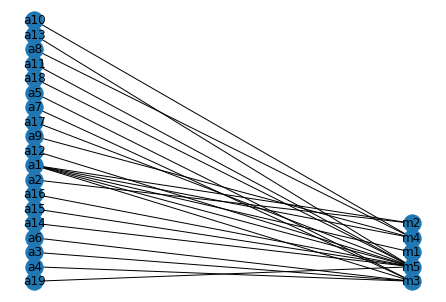

In [13]:
l, r = nx.bipartite.sets(A)
pos = {}

pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))

nx.draw(A, pos=pos, with_labels=True)
plt.show()

In [0]:
movies = []
actors = []
for i in A.nodes():
    if 'm' in i:
        movies.append(i)
    if 'a' in i:
        actors.append(i)
print('number of movies ', len(movies))
print('number of actors ', len(actors))

number of movies  1292
number of actors  3411


# CREATING RANDOM WALK

In [0]:

# Create the random walker
rw = UniformRandomMetaPathWalk(StellarGraph(A))

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["movie", "actor", "movie"],
    ["actor", "movie", "actor"]
]

walks = rw.run(nodes=list(A.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=1,        # number of random walks per root node 
               metapaths=metapaths
              )

print("Number of random walks: {}".format(len(walks)))

Number of random walks: 4703


# CREATING 128 DIMENSIONAL VECTOR OF ALL THE NODES(MOVIES AND ACTORS)

In [0]:
from gensim.models import Word2Vec
model = Word2Vec(walks, size=128, window=5)

In [0]:
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

(4703, 128)

In [0]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ A.node[node_id]['label'] for node_id in node_ids]

In [0]:
len(node_ids)

4703

# Collecting the indices of actors  and movies vectors from node_ids

In [0]:
movies_index=[]
actor_index=[]
for i,j in enumerate (node_ids):
    if 'm' in j:
      movies_index.append(i)
    if 'a' in j :
      actor_index.append(i)

In [0]:
actor_vector=np.zeros([0,128])
a=0
for i in actor_index:
    row_to_be_added=node_embeddings[i].reshape(1,-1)
    actor_vector=np.vstack((actor_vector,row_to_be_added))

In [0]:
actor_vector.shape

(3411, 128)

In [0]:
movie_vector=np.zeros([0,128])

for i in movies_index:
    row_to_be_added=node_embeddings[i].reshape(1,-1)
    movie_vector=np.vstack((movie_vector,row_to_be_added))

In [0]:
movie_vector.shape

(1292, 128)

In [0]:
# applying clustering
from sklearn.cluster import KMeans

In [0]:
from networkx.generators.ego import ego_graph
from networkx.classes.function import is_empty



# CLUSTERING BASED ON MOVIE NODES

---



# OPTIMUM NUMBER OF CLUSTERS IS DETERMINED USING THE BELOW FORMULA


# <img src='https://i.imgur.com/m2Lsz6i.png'>

In [0]:
from  tqdm import tqdm
clusters=[3,5,10, 30, 50, 100, 200, 500]
total_cost_list=[]
for f in tqdm(clusters):
  cluster=KMeans(n_clusters=f)
  df_actor['cluster']=cluster.fit_predict(actor_vector)
  nodes_list=[]
  for i in range(f):
    l=[]
    l.append(df_actor[df_actor['cluster']==i]['node'].values.tolist())
    nodes_list.extend(l)
  cost1=0
  cost2=0
  cost3=0
  total_cost=0
  cluster_length=[]
  for i in range(len(nodes_list)):
    U=nx.Graph()
    no_of_nodes=[]
    cluster_length.append(len(nodes_list[i]))
  
    for j in nodes_list[i]:
      a=ego_graph(A,j)
      no_of_nodes.append(a.number_of_nodes())
    
      if is_empty(U)==True:
        U.add_edges_from(a.edges(data=True))
        U.add_nodes_from(a.nodes(data=True))
      else:
        U = nx.compose(a,U)
  
    cost1+=(max(no_of_nodes)/U.number_of_nodes())
 
    movies = []
    for d in U.nodes():
      if 'm' in d:
        movies.append(d)
    
    cost3_den=len(set(movies))
    cost3+=(U.number_of_edges()/cost3_den)
   
  cost2=(max(cluster_length)/sum(cluster_length))
  cost2=cost2*(1-cost2)
  cost1=cost1/len(nodes_list)
  cost3=cost3/len(nodes_list)
  total_cost=cost1*cost2*cost3 
  total_cost_list.append((f,total_cost))


100%|██████████| 8/8 [03:05<00:00, 16.80s/it]


In [0]:
total_cost_list

[(3, 0.04234248806609455),
 (5, 0.05396947038342969),
 (10, 0.09603206621889626),
 (30, 0.14389553114216894),
 (50, 0.14072162097491886),
 (100, 0.12597761579279215),
 (200, 0.06531464919200117),
 (500, 0.03526867984326387)]

# The optimum number of clusters is '30', since the MAXIMUM(TOTAL COST)  = 0.143895

In [0]:
cluster=KMeans(n_clusters=30)
df_actor['cluster']=cluster.fit_predict(actor_vector)

In [0]:
df_actor.head(3)

,node,cluster
0,a973,3
1,a967,3
2,a964,3


# Dimensionality reduction

In [0]:
from sklearn.manifold import TSNE
transform = TSNE #PCA

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(actor_vector)

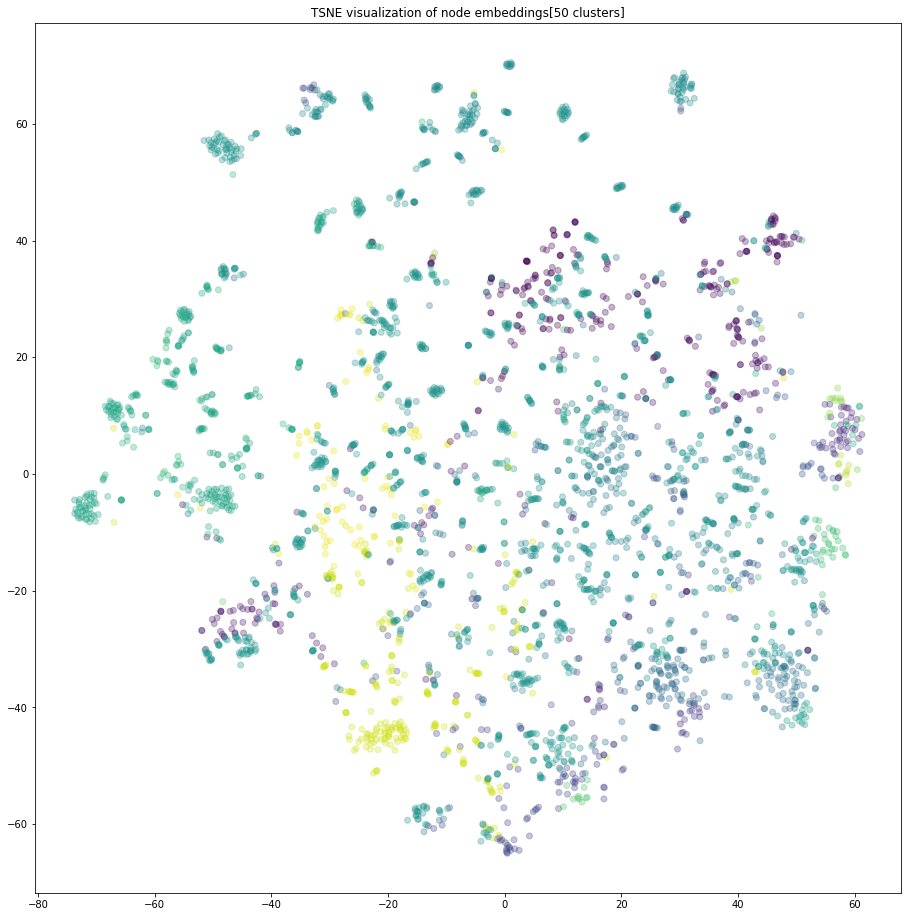

In [0]:
import numpy as np
# draw the points
label_map = { l: i for i, l in enumerate(np.unique(df_actor['cluster']))}
node_colours = [ label_map[target] for target in df_actor['cluster']]

plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:,0], 
            node_embeddings_2d[:,1], 
            c=node_colours, alpha=0.3)
plt.title('{} visualization of node embeddings[50 clusters]'.format(transform.__name__))

plt.show()

# The TSNE(T-Distributed Stochastic Neighbourhood Embedding), plot shows that the 'actors' can be grouped into clusters in HIGHER DIMENSIONS

#                                  CLUSTERING BASED ON MOVIE NODES

---



In [0]:
df_movie=pd.DataFrame(index=range(0,movie_vector.shape[0]),columns=['node','cluster'])

In [0]:
df_movie.shape

(1292, 2)

In [0]:
a=0
for i in node_ids:
  if 'm' in i:
    df_movie.node[a]=i
    a+=1

In [0]:
clusters=[3,5,10, 30, 50, 100, 200, 500]
total_cost_list=[]
for f in tqdm(clusters):
  cluster=KMeans(n_clusters=f)
  df_movie['cluster']=cluster.fit_predict(movie_vector)
  nodes_list=[]
  for i in range(f):
    l=[]
    l.append(df_movie[df_movie['cluster']==i]['node'].values.tolist())
    nodes_list.extend(l)
  cost1=0
  cost2=0
  cost3=0
  total_cost=0
  cluster_length=[]
  for i in range(len(nodes_list)):
    U=nx.Graph()
    no_of_nodes=[]
    cluster_length.append(len(nodes_list[i]))
  
    for j in nodes_list[i]:
      a=ego_graph(A,j)
      no_of_nodes.append(a.number_of_nodes())
    
      if is_empty(U)==True:
        U.add_edges_from(a.edges(data=True))
        U.add_nodes_from(a.nodes(data=True))
      else:
        U = nx.compose(a,U)
  
    cost1+=(max(no_of_nodes)/U.number_of_nodes())
 
    actors = []
    for d in U.nodes():
      if 'a' in d:
        actors.append(d)
    cost3_den=len(set(actors))
    cost3+=(U.number_of_edges()/cost3_den)
   
  cost2=(max(cluster_length)/sum(cluster_length))
  cost2=cost2*(1-cost2)
  cost1=cost1/len(nodes_list)
  cost3=cost3/len(nodes_list)
  total_cost=cost1*cost2*cost3 
  total_cost_list.append((f,total_cost))

  

100%|██████████| 8/8 [00:52<00:00,  6.24s/it]


In [0]:
total_cost_list

[(3, 0.01646266735338642),
 (5, 0.029124153141832327),
 (10, 0.028510713428128474),
 (30, 0.06518892395656764),
 (50, 0.07616557617345286),
 (100, 0.06619901712843801),
 (200, 0.05276662090776662),
 (500, 0.03555116484139068)]

# The optimum number of clusters is '50', since the MAX(TOTALCOST)=0.0761655 at 50 clusters

In [0]:
cluster=KMeans(n_clusters=30)
df_movie['cluster']=cluster.fit_predict(movie_vector)

# Dimensionality Reduction

In [0]:
transform = TSNE #PCA

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(movie_vector)

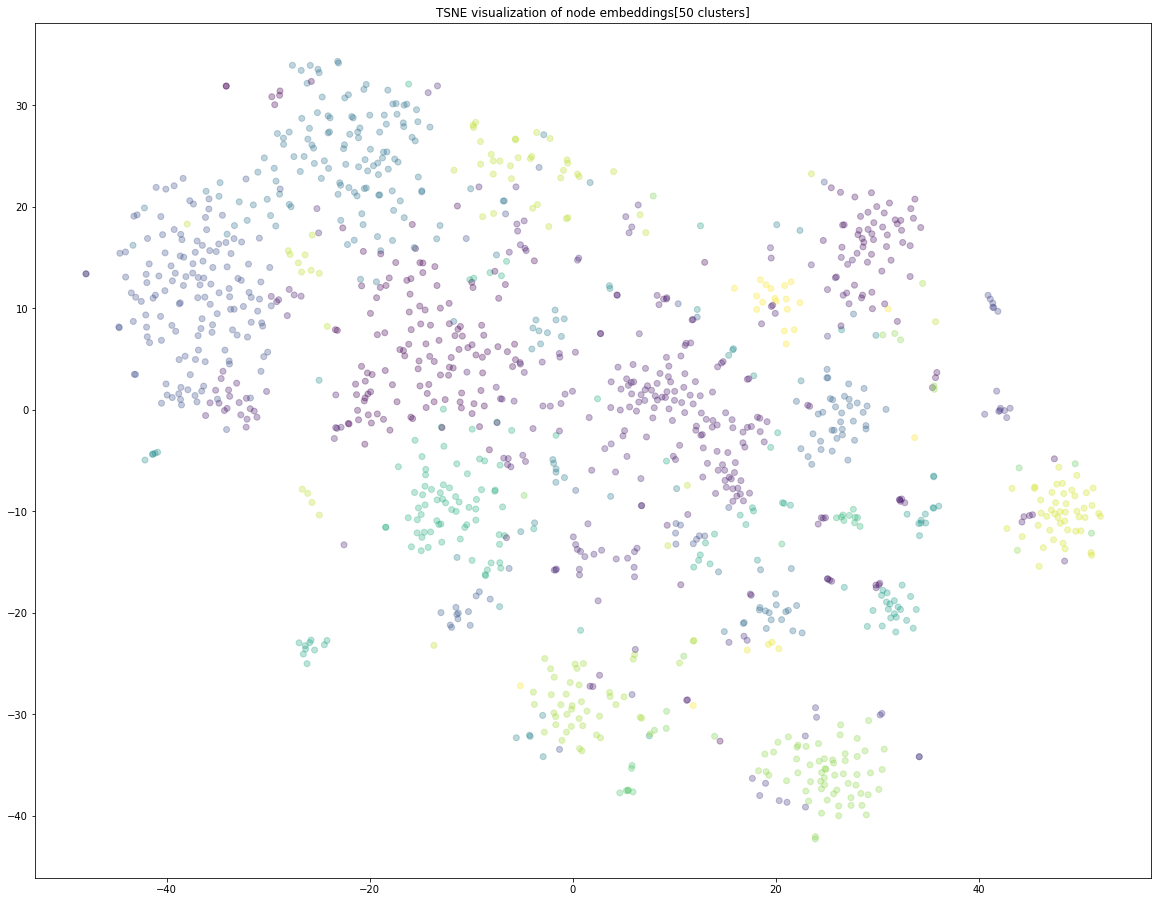

In [0]:
label_map = { l: i for i, l in enumerate(np.unique(df_movie['cluster']))}
node_colours = [ label_map[target] for target in df_movie['cluster']]

plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:,0], 
            node_embeddings_2d[:,1], 
            c=node_colours, alpha=0.3)
plt.title('{} visualization of node embeddings[50 clusters]'.format(transform.__name__))

plt.show()

# The TSNE(T-Distributed Stochastic Neighbourhood Embedding), plot shows that the 'movies' can be grouped into clusters in HIGHER DIMENSIONS